In [1]:
import copy
import random

import gym
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1")
torch.manual_seed(1423)
writer = SummaryWriter()
input_layers = env.observation_space.shape[0]
output = env.action_space.n
replay_size = 256
batch_size = 16
EPS = 1
EPS_DECAY = 5000
EPS_END = 0.05
GAMMA = torch.tensor(0.95).float().to(device)
network_update_steps = 5
episodes = 10000
learning_rate = 1e-3
CriticSync = 0

In [3]:
class BehavioralNetwork(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.Pass = nn.Sequential(
        nn.Linear(input, 64),
        nn.Tanh(),
        nn.Linear(64, output)
        )

    def forward(self, x):
        return self.Pass(x)

Actor = BehavioralNetwork(input = input_layers, output = output).to(device)
Critic = BehavioralNetwork(input = input_layers, output = output).to(device)

Critic.load_state_dict(Actor.state_dict())
# def build_nn(layer_sizes):
#     assert len(layer_sizes) > 1
#     layers = []
#     for index in range(len(layer_sizes)-1):
#         linear = nn.Linear(layer_sizes[index], layer_sizes[index+1])
#         act =    nn.Tanh() if index < len(layer_sizes)-2 else nn.Identity()
#         layers += (linear,act)
#     return nn.Sequential(*layers)

# Actor = build_nn(layer_sizes = [input_layers, 64, output]).to(device)
# Critic = copy.deepcopy(Actor).to(device)

# Ora non ho ben chiaro se il training fatto sull'attore è fatto quando colleziono una certa quantità di stati diverso dall'experience replay e poi faccio il training, rendendo questi stati però scorrelati usando un DataLoader o cose del genere, oppure faccio il training quando l'experience replay è pieno? Perchè il problema è che c'è il "Forgetting" e quindi il training per un dato nuovo dal dataset tende a rimpiazzare cosa è stato appena imparato allo step precedente come espresso da questa frase:
# "Today’s deep learning methods struggle to learn rapidly in the incremental, online settings that are most natural for the reinforcement learning algorithms emphasized in this book. The problem is sometimes described as one of “catastrophic interference” or “correlated data.” When something new is learned it tends to replace what has previously been learned rather than adding to it, with the result that the benefit of the older learning is lost. Techniques such as “replay buffers” are often used to retain and replay old data so that its benefits are not permanently lost¹."



# Il motivo per il quale abbiamo 2 network diverse è che una deve genere la "verità", cioè il dato che ci serve per fare il training della Q-network che è in qualche modo "supervised". Questo dato sarebbe una state-action value e ci dice qual è l'azione migliore da scegliere in un certo stato, e l'errore viene calcolato a partire da questo dato per trainare invece la Q-Network che sceglie l'azione!

optimizer = torch.optim.Adam(Actor.parameters(), lr= learning_rate)
loss_fn = nn.MSELoss()

In [4]:

def convert_data(experience, batch_size):
    if(len(experience) < batch_size):
        batch_size = len(experience)
    data_batch = random.sample(experience, batch_size)
    states_t = torch.tensor([exp[0] for exp in data_batch]).float().to(device)
    actions_t = torch.tensor([exp[1] for exp in data_batch]).float()
    rewards_t = torch.tensor([exp[2] for exp in data_batch]).float().to(device)
    next_states_t =  torch.tensor([exp[3] for exp in data_batch]).float().to(device)
    return states_t, actions_t, rewards_t, next_states_t


def train(training_data, CriticSync, batch_size):
    states_t, actions_t, rewards_t, next_states_t = convert_data(training_data, batch_size)
    if CriticSync == network_update_steps:
        Critic.load_state_dict(Actor.state_dict())
        CriticSync = 0
    qs = Actor(states_t)
    bestAction, _ = torch.max(qs, axis=1)

    with torch.no_grad():
        q_next = Critic(next_states_t)
    bestNextAction,_ = torch.max(q_next,axis=1)
    target = rewards_t + GAMMA*bestNextAction

    loss = loss_fn(bestAction, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    CriticSync += 1
    return CriticSync

def get_action(state, EPS):
    # We do not require gradient at this point, because this function will be used either
    # during experience collection or during inference
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        Qp = Actor(state)
    Q,A = torch.max(Qp, axis=0)
    A = A.item() if torch.rand(1,) > EPS else torch.randint(0,2,(1,)).item()
    return A

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Tatonta\AppData\Local\Temp\ipykernel_6752\1458641052.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  states_t = torch.tensor([exp[0] for exp in data_batch]).float().to(device)
100%|██████████| 10000/10000 [13:45<00:00, 12.12it/s]


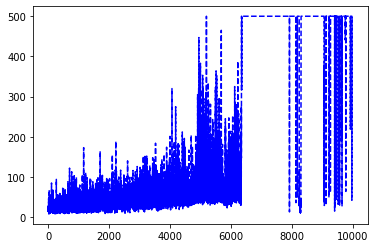

In [5]:
experience_replay = deque(maxlen = replay_size)

index = 0
for i in range(replay_size):
    obs = env.reset()
    done = False
    while not done:
        action = get_action(obs, EPS)
        obs_next, R, done, info = env.step(action)
        experience_replay.append([obs, action, R, obs_next])
        obs = obs_next
        index += 1
        if( index > replay_size ):
            break

index = 128
totalReward = np.zeros(episodes)
for i in tqdm(range(episodes)):
    obs = env.reset()
    done = False
    epsReward = 0
    while not done:
        action = get_action(obs, EPS)
        obs_next, R, done, _ = env.step(action)
        epsReward += R
        experience_replay.append([obs, action, R, obs_next])
        obs = obs_next
        index += 1
        if (index > 128):
            index = 0
            for j in range(4):
                CriticSync = train(experience_replay, CriticSync, batch_size)
    totalReward[i] = epsReward
    writer.add_scalar("Episode Total Reward", totalReward[i], i)
    if EPS > 0.05 :
        EPS -= (1 / 5000)

#TROVATO IL BUG!!!! Il problema era con CriticSync che nel ciclo for veniva passato come parametro e poi aggiornato dentro la funzione, il problema però è che ad ogni passo del ciclo for, veniva passato parametro il CriticSync non aggiornato, e quindi rimaneva sempre "0" e non aggiornava mai la target_network (chiamata anche Critic)
plt.plot(totalReward, 'b--')
plt.show()

In [8]:
env = gym.make("CartPole-v1")
epsReward = np.zeros(2)
for i in tqdm(range(2)):
    obs = env.reset()
    done = False
    while not done:
        A =  get_action(obs, EPS=0)
        obs, reward, done, info = env.step(A)
        epsReward += reward
        env.render(mode="human")
    print("episode : {}, reward : {}".format(i,epsReward))

  0%|          | 0/2 [01:37<?, ?it/s]


KeyboardInterrupt: 